# Regression Fundamentals: Implementing Linear Regression

In the previous session, we explored what linear regression is, how it
works conceptually, and why it’s such a powerful tool. We saw how
regression finds the line of best fit by minimising prediction errors,
and we understood the core components: intercepts, slopes, and
residuals.

Now it’s time to put that theory into practice. In this session, we’ll
learn how to actually build regression models in Python, interpret their
outputs, check whether our models are valid, and generate insights from
them.

We’ll cover two main approaches to regression in Python:

-   `scikit-learn` - Focused on prediction and machine learning
    workflows.
-   `statsmodels` - Focused on statistical inference and hypothesis
    testing.

Let’s get started by loading our data and packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

# set visualisation style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# load palmer penguins data
url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-04-15/penguins.csv'
df = pd.read_csv(url)

# drop missing values for simplicity
df = df.dropna()

## Building Predictive Models Using Scikit-Learn

`scikit-learn` (`sklearn`) is Python’s most popular library for machine
learning. Its regression tools are designed for building predictive
models, and it is optimised for generalising well on new data.

### Simple Linear Regression

A simple linear regression has one predictor variable. Let’s predict
body mass from flipper length.

In [3]:
# prepare the data
# sklearn requires 2D arrays for X (predictors) and 1D arrays for y (outcome)
X = df[['flipper_len']]  # double brackets create a dataframe
y = df['body_mass']       # single bracket creates a series

# create and fit the model
model = LinearRegression()
model.fit(X, y)

# get the intercept
intercept = model.intercept_
print(f"Intercept = {intercept:.2f}g")

# get the slope
slope = model.coef_[0]
print(f"Slope = {slope:.2f}g per mm")

Intercept = -5872.09g
Slope = 50.15g per mm

The fitted model object contains everything we need: coefficients,
predictions, and model performance metrics.

The intercept ($\beta_0$) = -5872.1g. The intercept tells us the
predicted body mass when flipper length is 0mm. This intercept value is
not meaningful because a flipper length of zero is implausible and
ultimately nonsensical (if they have flippers, they must be longer than
0mm)[1], but we need the intercept to fit the model.

The slope ($\beta_1$) = 50.2g/mm. The slope tells us that each
additional mm increase in flipper length predicts ~50g increase in body
mass.

### Making Predictions

Once we have a fitted model, we can use it to predict body mass for any
flipper length.

[1] For explanatory models, it is generally best-practice to transform
the data so that the intercept is meaningful. For example, subtracting
the mean flipper length from each observation (otherwise known as
centering) so that the zero value represents the average flipper length
and the intercept represents the average body mass for the average
flipper length.

In [4]:
# predict body mass for all penguins in our dataset
y_pred = model.predict(X)

# add predictions to our dataframe
df['predicted_mass'] = y_pred
df['residual'] = df['body_mass'] - df['predicted_mass']

# look at some predictions
print("Sample predictions:")
print(df[['flipper_len', 'body_mass', 'predicted_mass', 'residual']].head(10))

Sample predictions:
    flipper_len  body_mass  predicted_mass    residual
0         181.0     3750.0     3205.648453  544.351547
1         186.0     3800.0     3456.414782  343.585218
2         195.0     3250.0     3907.794176 -657.794176
4         193.0     3450.0     3807.487644 -357.487644
5         190.0     3650.0     3657.027846   -7.027846
6         181.0     3625.0     3205.648453  419.351547
7         195.0     4675.0     3907.794176  767.205824
12        182.0     3200.0     3255.801719  -55.801719
13        191.0     3800.0     3707.181112   92.818888
14        198.0     4400.0     4058.253974  341.746026

We can plot the predictions too.

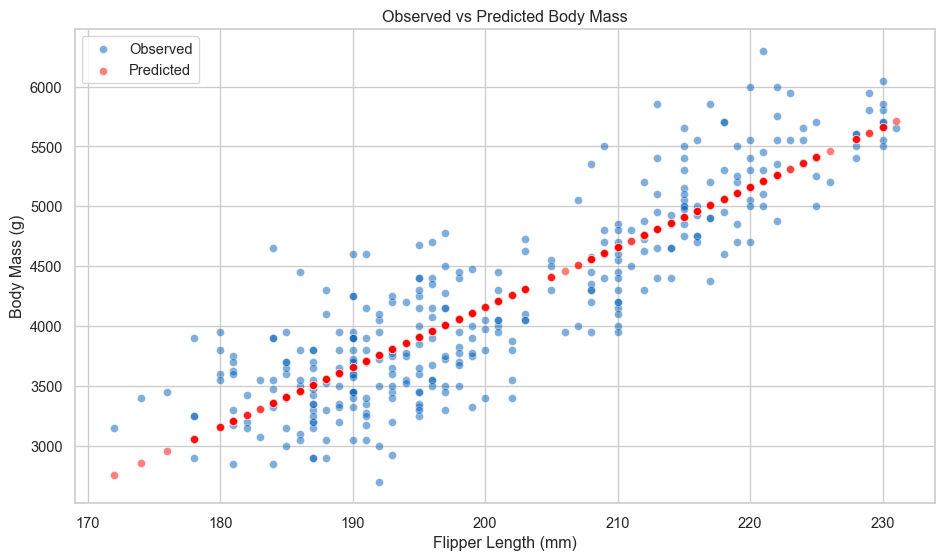

In [5]:
# plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df, x='flipper_len', y='body_mass', color='#005EB8', alpha=0.5, ax=ax, label='Observed')
sns.scatterplot(data=df, x='flipper_len', y='predicted_mass', color='red', alpha=0.5, ax=ax, label='Predicted')

ax.set_xlabel('Flipper Length (mm)')
ax.set_ylabel('Body Mass (g)')
ax.set_title('Observed vs Predicted Body Mass')
ax.legend()

plt.tight_layout()
plt.show()

We can also predict for new data.

In [6]:
# predict for hypothetical penguins
new_penguins = pd.DataFrame({
    'flipper_len': [180, 200, 220]
})

new_predictions = model.predict(new_penguins)

print("\nPredictions for new penguins:")
for flipper, mass in zip(new_penguins['flipper_len'], new_predictions):
    print(f"Flipper length: {flipper}mm --> Predicted mass: {mass:.0f}g")


Predictions for new penguins:
Flipper length: 180mm --> Predicted mass: 3155g
Flipper length: 200mm --> Predicted mass: 4159g
Flipper length: 220mm --> Predicted mass: 5162g

### Model Performance Metrics

An important part of predictive modelling is evaluation. We need to test
how well our model is performing! `sklearn` provides a wide variety of
metrics for assessing model performance. We will look at $\text{R}^2$
and RMSE.

In [7]:
# r-squared: proportion of variance explained
r2 = r2_score(y, y_pred)

# root mean squared error: average prediction error in grams
rmse = np.sqrt(mean_squared_error(y, y_pred))

The $\text{R}^2$ = 0.76, which suggests that flipper length explains a
significant amount of the variance in penguin body mass, while the RMSE
indicates that the average prediction error is 392.16g. This means that
predictions are, on average, off by 392.16g.

> **Note**
>
> There is no rule of thumb or minimum threshold for good prediction
> error. It all depends on what you are trying to predict and what is
> needed for predictions to be useful. Another model trying to predict
> something completely different might have much larger prediction
> errors but this still be useful in context. It is always necessary to
> judge a model in context.

### Multiple Linear Regression

Now let’s add more predictors. Multiple regression lets us understand
the effect of each variable while controlling for the others.

In [8]:
# add bill length and bill depth as predictors
X_multi = df[['flipper_len', 'bill_len', 'bill_dep']]
y = df['body_mass']

# fit the model
model_multi = LinearRegression()
model_multi.fit(X_multi, y)

# extract coefficients
print("Multiple regression coefficients:")
print(f"Intercept: {model_multi.intercept_:.2f}g")
for name, coef in zip(X_multi.columns, model_multi.coef_):
    print(f"  {name}: {coef:.2f}g per unit")

# compare model performance
y_pred_multi = model_multi.predict(X_multi)
r2_multi = r2_score(y, y_pred_multi)
rmse_multi = np.sqrt(mean_squared_error(y, y_pred_multi))

print(f"\nModel comparison:")
print(f"Simple model (flipper only):   R² = {r2:.3f}, RMSE = {rmse:.1f}g")
print(f"Multiple model (three vars):   R² = {r2_multi:.3f}, RMSE = {rmse_multi:.1f}g")

Multiple regression coefficients:
Intercept: -6445.48g
  flipper_len: 50.76g per unit
  bill_len: 3.29g per unit
  bill_dep: 17.84g per unit

Model comparison:
Simple model (flipper only):   R² = 0.762, RMSE = 392.2g
Multiple model (three vars):   R² = 0.764, RMSE = 390.6g

Adding bill measurements improves our model slightly. Each predictor
contributes information beyond what the others provide.

## Building Inferential Models Using Statsmodels

`statsmodels` is designed for statistical inference[1]. It provides
detailed output about uncertainty, hypothesis tests, and model
diagnostics. This is what you want when your goal is understanding
relationships rather than pure prediction.

Adding predictors is straightforward with the formula interface.

[1] Statistical inference is the process of drawing conclusions about a
population (or an effect occurring in the real-world) based on sample
data.

In [9]:
# multiple regression with formula
model_sm = smf.ols('body_mass ~ flipper_len + bill_len + bill_dep', data=df).fit()

print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:              body_mass   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     354.9
Date:                Thu, 26 Feb 2026   Prob (F-statistic):          9.26e-103
Time:                        19:54:13   Log-Likelihood:                -2459.8
No. Observations:                 333   AIC:                             4928.
Df Residuals:                     329   BIC:                             4943.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6445.4760    566.130    -11.385      

The `statsmodels` summary is dense but incredibly informative. Here’s
what matters most.

-   `coef` - The estimated effect size of each variable holding the
    others constant
-   `std err` - Uncertainty in the estimate
-   `t` - Test statistic (coef / std err)
-   `P>|t|` - p-value for null hypothesis that coefficient = 0
-   `[0.025, 0.975]` - 95% confidence interval

Focus on effect sizes first, then uncertainty. The coefficient tells you
the magnitude of the relationship. The confidence interval tells you how
precisely we’ve estimated it. Don’t obsess over $\text{R}^2$[1] or
p-values. The most important part of the model is the coefficients.

> **Note**
>
> The p-value is useful as a diagnostic, indicating whether you have
> enough data, but it doesn’t tell you whether the effect is meaningful
> or important.

We can also produce a simpler regression table, if the above is
overwhelming.

[1] A model with $\text{R}^2$ = 0.3 can still be incredibly useful if
the effects are meaningful and the predictions are good enough for your
purpose.

In [10]:
# extract just the coefficients table
print(model_sm.summary().tables[1])

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6445.4760    566.130    -11.385      0.000   -7559.167   -5331.785
flipper_len    50.7621      2.497     20.327      0.000      45.850      55.675
bill_len        3.2929      5.366      0.614      0.540      -7.263      13.849
bill_dep       17.8364     13.826      1.290      0.198      -9.362      45.035

Styled Tables (Click to Expand)

For presentations and reports, we can create publication-ready tables.

In [11]:
from great_tables import GT, md, html
from great_tables import loc, style

# fit three models for comparison
model1 = smf.ols('body_mass ~ flipper_len', data=df).fit()
model2 = smf.ols('body_mass ~ flipper_len + bill_len + bill_dep', data=df).fit()
model3 = smf.ols('body_mass ~ flipper_len + bill_len + bill_dep + C(species)', data=df).fit()

# create a dataframe with model results
results_df = pd.DataFrame({
    'Variable': ['Intercept', 'Flipper Length', 'Bill Length', 'Bill Depth', 
                 'Chinstrap', 'Gentoo'],
    'Model 1': [
        f"{model1.params['Intercept']:.1f}",
        f"{model1.params['flipper_len']:.2f}***",
        '—', '—', '—', '—'
    ],
    'Model 2': [
        f"{model2.params['Intercept']:.1f}",
        f"{model2.params['flipper_len']:.2f}***",
        f"{model2.params['bill_len']:.2f}***",
        f"{model2.params['bill_dep']:.2f}",
        '—', '—'
    ],
    'Model 3': [
        f"{model3.params['Intercept']:.1f}",
        f"{model3.params['flipper_len']:.2f}***",
        f"{model3.params['bill_len']:.2f}***",
        f"{model3.params['bill_dep']:.2f}**",
        f"{model3.params['C(species)[T.Chinstrap]']:.1f}***",
        f"{model3.params['C(species)[T.Gentoo]']:.1f}***"
    ]
})

# add model statistics
stats_df = pd.DataFrame({
    'Variable': ['', 'N', 'R²', 'Adj. R²', 'AIC'],
    'Model 1': ['', f"{int(model1.nobs)}", f"{model1.rsquared:.3f}", 
                f"{model1.rsquared_adj:.3f}", f"{model1.aic:.1f}"],
    'Model 2': ['', f"{int(model2.nobs)}", f"{model2.rsquared:.3f}", 
                f"{model2.rsquared_adj:.3f}", f"{model2.aic:.1f}"],
    'Model 3': ['', f"{int(model3.nobs)}", f"{model3.rsquared:.3f}", 
                f"{model3.rsquared_adj:.3f}", f"{model3.aic:.1f}"]
})

combined_df = pd.concat([results_df, stats_df], ignore_index=True)

# create styled table
table = (
    GT(combined_df)
    .tab_header(
        title="Regression Models Predicting Penguin Body Mass",
        subtitle="Coefficients with significance stars (* p<0.05, ** p<0.01, *** p<0.001)"
    )
    .tab_spanner(
        label="Model Specifications",
        columns=['Model 1', 'Model 2', 'Model 3']
    )
    .tab_style(
        style=style.text(weight="bold"),
        locations=loc.body(rows=[6, 7, 8, 9, 10])
    )
    .tab_style(
        style=style.borders(sides="top", weight="2px"),
        locations=loc.body(rows=[6])
    )
    .cols_align(
        align="center",
        columns=['Model 1', 'Model 2', 'Model 3']
    )
    .cols_align(
        align="left",
        columns=['Variable']
    )
)

table

## Adding Categorical Variables

`statsmodels` handles categorical variables automatically with the
formula interface.

In [12]:
# add species as a categorical predictor
# statsmodels automatically creates dummy variables
model_species_sm = smf.ols('body_mass ~ flipper_len + bill_len + bill_dep + C(species)', 
                           data=df).fit()

print(model_species_sm.summary())

                            OLS Regression Results                            
Dep. Variable:              body_mass   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     369.1
Date:                Thu, 26 Feb 2026   Prob (F-statistic):          4.22e-132
Time:                        19:54:14   Log-Likelihood:                -2384.8
No. Observations:                 333   AIC:                             4782.
Df Residuals:                     327   BIC:                             4805.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -4

The `C()` wrapper tells `statsmodels` to treat species as categorical.
The model automatically creates “dummy variables”, which splits the
categorical variable into multiple columns, with each column being a
binary variable representing a category (where the variable equals one
when that category appears in the original column).

When creating the dummy variables, the model drops one category to use
it as the reference category against which the other categories are
compared. This means that coefficients for those categories tell us how
much the outcome variable increases or decreases compared against the
reference category that was dropped.

For example, the model specified above uses Adelie penguins as the
reference category (it chooses by alphabetical order by default), and
the coefficients represent the species effects relative to Adelie
penguins.

In [13]:
print("\nSpecies effects relative to Adelie:")
for var in model_species_sm.params.index:
    if 'species' in var:
        coef = model_species_sm.params[var]
        ci = model_species_sm.conf_int().loc[var]
        species = var.split('[T.')[1].rstrip(']')
        print(f"{species:12s}: {coef:7.0f}g heavier [{ci[0]:7.0f}, {ci[1]:7.0f}]")


Species effects relative to Adelie:
Chinstrap   :    -497g heavier [   -659,    -335]
Gentoo      :     965g heavier [    686,    1244]

## Coefficient Plots

Coefficient plots show effect sizes and their uncertainty at a glance.

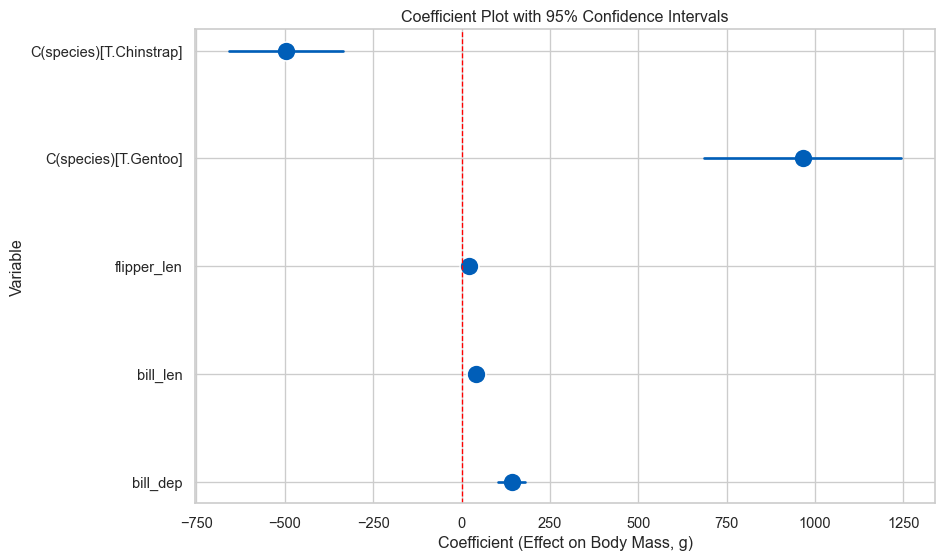

In [14]:
# extract coefficients and confidence intervals
coefs = model_species_sm.params.drop('Intercept')
conf_int = model_species_sm.conf_int().drop('Intercept')

# create dataframe for plotting
coef_data = pd.DataFrame({
    'Variable': coefs.index,
    'Coefficient': coefs.values,
    'Lower': conf_int[0].values,
    'Upper': conf_int[1].values
})

# plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=coef_data, x='Coefficient', y='Variable', s=200, 
                color='#005EB8', ax=ax)
for idx, row in coef_data.iterrows():
    ax.plot([row['Lower'], row['Upper']], [row['Variable'], row['Variable']], 
            color='#005EB8', linewidth=2)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Coefficient (Effect on Body Mass, g)')
ax.set_title('Coefficient Plot with 95% Confidence Intervals')
plt.tight_layout()
plt.show()

Variables whose CI doesn’t cross zero have effects distinguishable from
zero. But remember: focus on effect sizes, not just significance!

# Regression Assumptions and Diagnostics

Linear regression makes several assumptions. When these hold, OLS gives
us the Best Linear Unbiased Estimator (BLUE). When they don’t, we need
to either fix the problem[1] or acknowledge the limitations.

## The Gauss-Markov Theorem

Under certain conditions, OLS is BLUE:

1.  **Linearity**: The relationship between X and Y is linear
2.  **Independence**: Observations are independent of each other
3.  **Homoscedasticity**: Variance of errors is constant across X
4.  **No perfect multicollinearity**: Predictors aren’t perfectly
    correlated
5.  **Exogeneity**: Errors have mean zero (no systematic bias)

Additionally, for valid inference (confidence intervals, p-values), we
need:

1.  **Normality**: Errors are normally distributed (or we have a large
    sample)

Let’s check these assumptions systematically.

## Diagnostic Plots

We’ll create a set of diagnostic plots to check our assumptions. First,
let’s fit a model to diagnose.

[1] Fixing the problem can take many shapes. It could involve
transforming the data to fit the model better, adding (or removing)
variables that improve model fit, or fitting a different type of
regression model entirely.

In [15]:
# fit our model with species
model = model_species_sm  # use the statsmodels model from earlier

# get predictions and residuals
df['fitted'] = model.fittedvalues
df['residuals'] = model.resid
df['standardised_residuals'] = model.resid_pearson

### 1. Residuals vs Fitted (Linearity & Homoscedasticity)

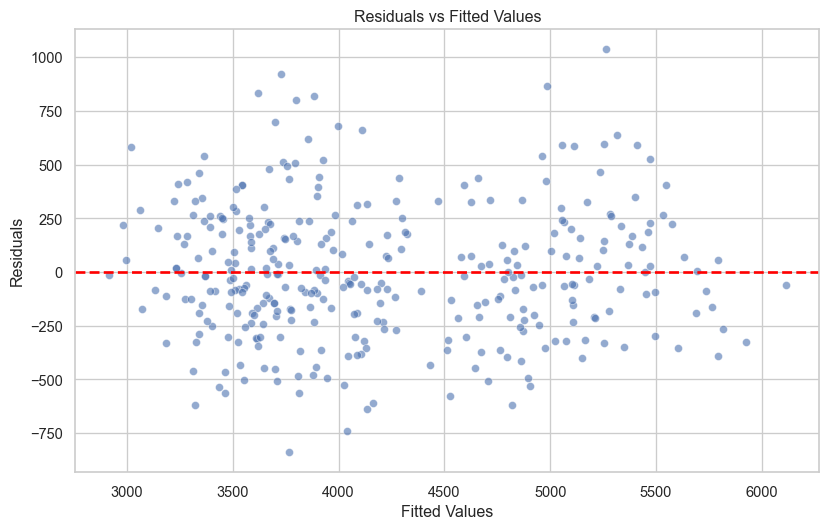

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=df['fitted'], y=df['residuals'], alpha=0.6, ax=ax)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs Fitted Values')
plt.show()

The observations should appear to be randomly scattered around zero, and
the spread around zero should be constant across the range of fitted
values. If you can see a pattern or trend, this suggests the linearity
assumption is violated, and if the observations are funnel-shaped, this
suggests that the homoscedasticity assumption is violated.

### 2. Q-Q Plot (Normality)

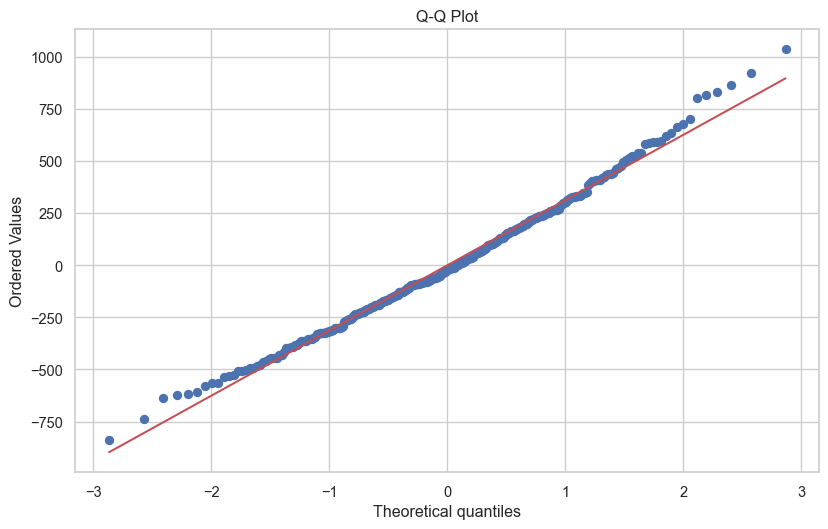

In [17]:
from scipy import stats

fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(df['residuals'], dist="norm", plot=ax)
ax.set_title('Q-Q Plot')
plt.show()

The closer to the red line, the better. However, some deviation is
generally fine, and as sample size increases this becomes less of a
concern. The very small deviations from the line above are not a cause
for concern.

### 3. Scale-Location Plot (Homoscedasticity)

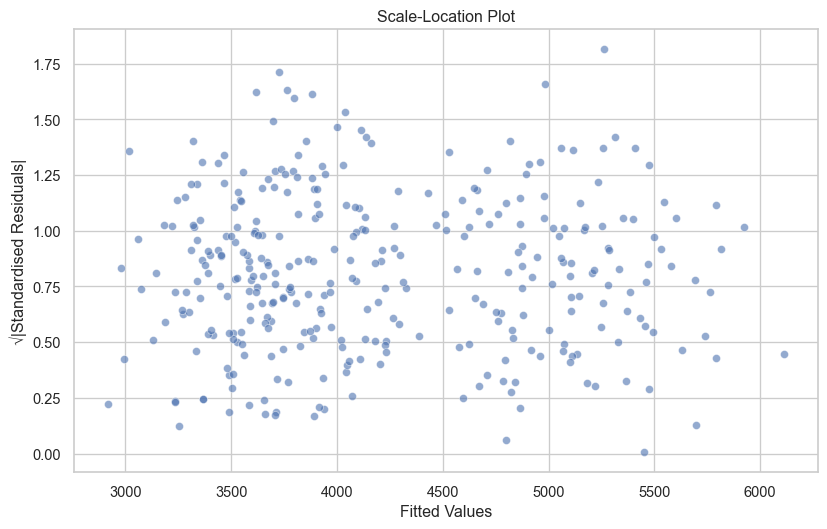

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=df['fitted'], y=np.sqrt(np.abs(df['standardised_residuals'])), alpha=0.6, ax=ax)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('√|Standardised Residuals|')
ax.set_title('Scale-Location Plot')
plt.show()

If there is an observable trend or pattern in your Scale-Location plot,
this indicates heteroscedasticity.

### 4. Residuals vs Leverage (Influential Points)

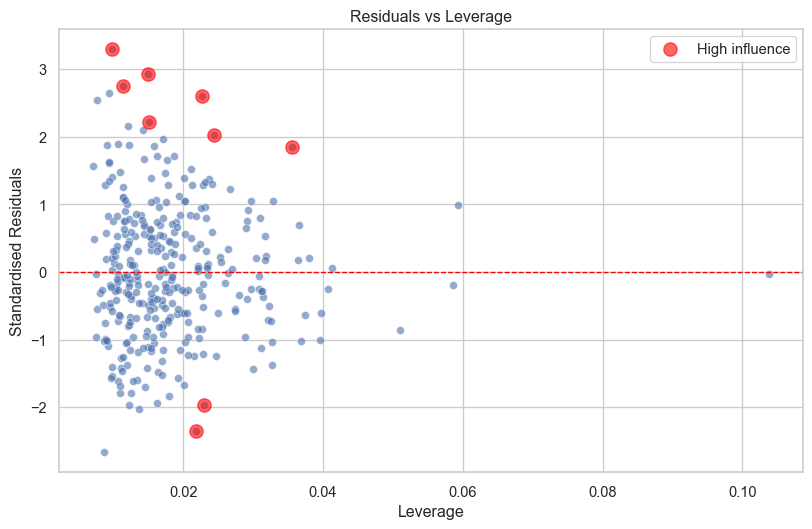

In [19]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(model)
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=leverage, y=df['standardised_residuals'], alpha=0.6, ax=ax)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Leverage')
ax.set_ylabel('Standardised Residuals')
ax.set_title('Residuals vs Leverage')

# highlight high influence points
high_influence = cooks_d > 4/len(df)
if high_influence.any():
    ax.scatter(leverage[high_influence], df['standardised_residuals'][high_influence], 
               color='red', s=100, alpha=0.6, label='High influence')
    ax.legend()
plt.show()

Points that are significantly higher or lower than zero and with high
leverage are potentially a problem.

However, I would caution against just removing outliers because they
have a significant influence. If those outliers are real observations,
should they really be discarded?

Quick Diagnostic Function (Click to Expand)

Let’s create a helper function to generate all diagnostic plots at once.

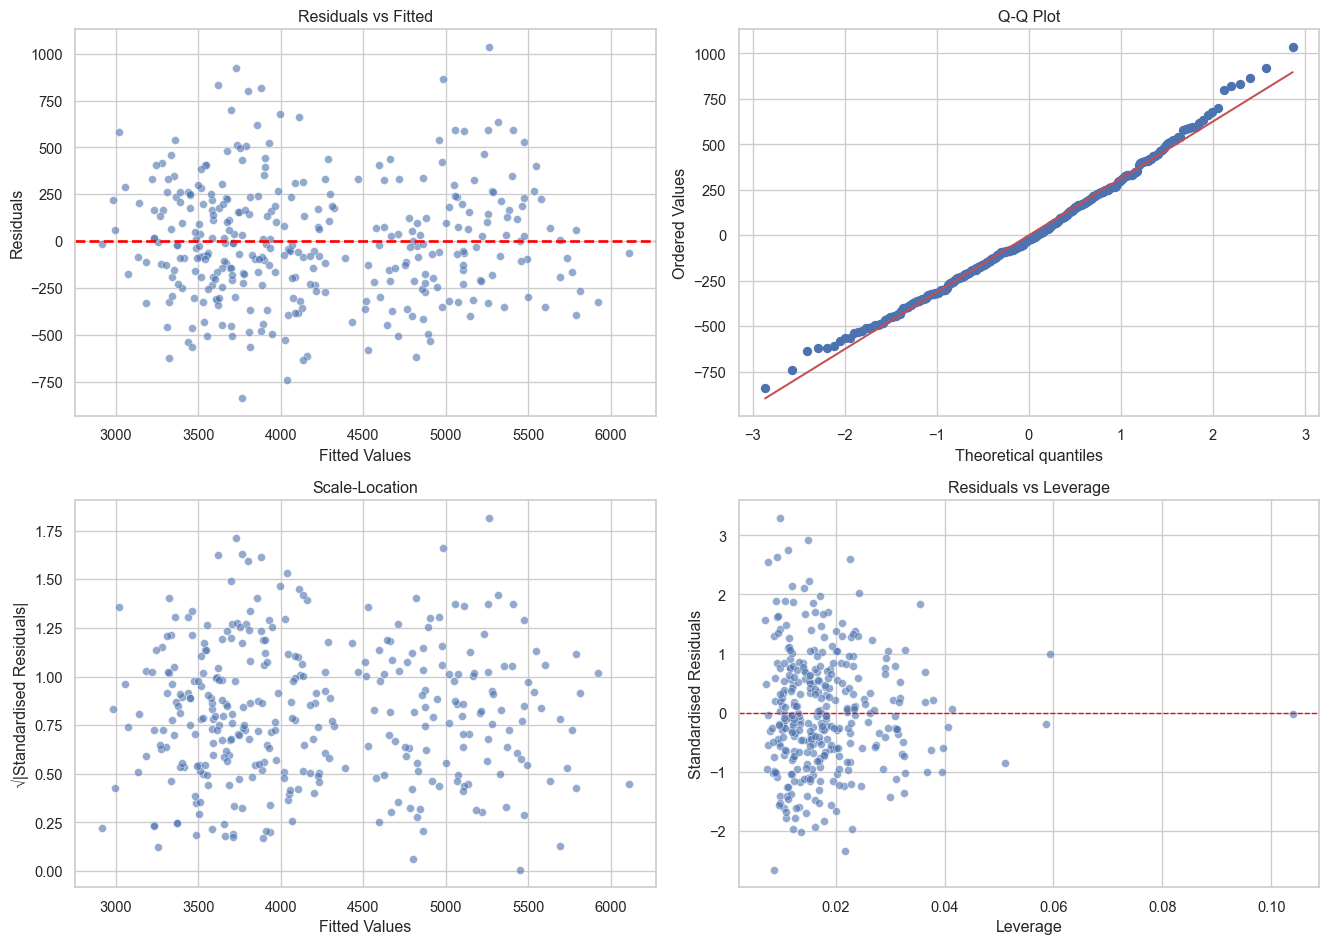

In [20]:
def plot_diagnostics(model, data=None):
    """
    Create a 2x2 grid of diagnostic plots for a statsmodels regression model.
    
    Parameters:
    -----------
    model : statsmodels regression model
        A fitted statsmodels OLS model
    data : pandas DataFrame, optional
        The data used to fit the model (for some plot enhancements)
    """
    # get residuals and fitted values
    fitted = model.fittedvalues
    residuals = model.resid
    standardised_residuals = model.resid_pearson
    
    # calculate leverage and influence
    influence = OLSInfluence(model)
    leverage = influence.hat_matrix_diag
    
    # create 2x2 plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. residuals vs fitted
    sns.scatterplot(x=fitted, y=residuals, alpha=0.6, ax=axes[0, 0])
    axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Fitted')
    
    # 2. q-q plot
    stats.probplot(residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot')
    
    # 3. scale-location
    sns.scatterplot(x=fitted, y=np.sqrt(np.abs(standardised_residuals)), alpha=0.6, ax=axes[1, 0])
    axes[1, 0].set_xlabel('Fitted Values')
    axes[1, 0].set_ylabel('√|Standardised Residuals|')
    axes[1, 0].set_title('Scale-Location')
    
    # 4. residuals vs leverage
    sns.scatterplot(x=leverage, y=standardised_residuals, alpha=0.6, ax=axes[1, 1])
    axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[1, 1].set_xlabel('Leverage')
    axes[1, 1].set_ylabel('Standardised Residuals')
    axes[1, 1].set_title('Residuals vs Leverage')
    
    plt.tight_layout()
    plt.show()

# use the function
plot_diagnostics(model_species_sm)

## Checking for Multicollinearity

When predictors are highly correlated with each other, coefficient
estimates become unstable. We can check this using Variance Inflation
Factors (VIF).

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# calculate VIF for each predictor
# need to add constant for VIF calculation
X_with_const = sm.add_constant(df[['flipper_len', 'bill_len', 'bill_dep']])

vif_data = pd.DataFrame()
vif_data['Variable'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) 
                   for i in range(X_with_const.shape[1])]

print("Variance Inflation Factors:")
print(vif_data)

Variance Inflation Factors:
      Variable         VIF
0        const  691.005294
1  flipper_len    2.633327
2     bill_len    1.850958
3     bill_dep    1.593411

The rule of thumb:

-   VIF of greater than five = No multicollinearity
-   VIF of between five and ten = Moderate multicollinearity
-   VIF greater than ten = High multicollinearity

## What Happens When Assumptions Are Violated?

Understanding assumptions helps you know when you can bend or break the
rules.

-   Linearity - Coefficients are biased. Try transformations (log,
    polynomial) or non-linear models.
-   Independence - Standard errors are wrong (usually too small). Use
    clustered standard errors or multilevel models.
-   Homoscedasticity - Standard errors are wrong. Use robust standard
    errors (HC3, HC4). Predictions are still unbiased.
-   Normality - With large samples, not a big problem due to central
    limit theorem. With small samples, confidence intervals may be
    wrong.
-   Multicollinearity - Coefficients are unstable and hard to interpret,
    but predictions are fine. Remove or combine correlated predictors.

As you gain experience, you’ll learn when violations matter and when
they don’t. For now, check diagnostics and flag any concerns.

# Summary

-   `sklearn` for prediction - Fast, consistent API for building models.
-   `statsmodels` for inference - Detailed statistical output for
    understanding.
-   Assumptions matter - Check diagnostics, understand when violations
    are problematic.
-   Effect sizes over p-values - Focus on what matters practically.

Linear regression is a powerful tool, and learning the principles of
linear regression (thinking about predictions, uncertainty, assumptions,
and interpretation) apply to much more complex models.